# ai4 for health related matters

## dependencies

In [91]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

## dataset stuff

### read the dataset

In [92]:
df = pd.read_csv('dataset.csv')
df = df.sample(frac = 1)
df

age   sex   cp   trestbps   chol   fbs   restecg   thalach   exang  \
193   62     0    4        138    294     1         0       106       0   
130   54     1    3        120    258     0         2       147       0   
251   58     1    4        146    218     0         0       105       0   
41    40     1    1        140    199     0         0       178       1   
58    54     1    3        125    273     0         2       152       0   
..   ...   ...  ...        ...    ...   ...       ...       ...     ...   
278   57     1    2        154    232     0         2       164       0   
219   59     1    4        138    271     0         2       182       0   
82    39     1    3        140    321     0         2       182       0   
85    44     1    3        140    235     0         2       180       0   
276   66     0    3        146    278     0         2       152       0   

      oldpeak   slope   ca  thal   diagnosis  
193       1.9       2  3.0   3.0           2  
130       0.4       2  0.0   7.0           0  
251       2.0       2  1.0   7.0           1  
41        1.4       1  0.0   7.0           0  
58        0.5       3  1.0   3.0           0  
..        ...     ...  ...   ...         ...  
278       0.0       1  1.0   3.0           1  
219       0.0       1  0.0   3.0           0  
82        0.0       1  0.0   3.0           0  
85        0.0       1  0.0   3.0           0  
276       0.0       2  1.0   3.0           0  

[303 rows x 14 columns]

### train_test split

In [93]:
ratio = 0.95 # 90:10 train:test ratio
train_set = df.sample(frac=ratio)

# Dropping all those indexes from the dataframe that exists in the train_set
test_set = df.drop(train_set.index)
train_set.shape, test_set.shape

train_set
test_set

age   sex   cp   trestbps   chol   fbs   restecg   thalach   exang  \
217   46     0    4        138    243     0         2       152       1   
109   39     1    4        118    219     0         0       140       0   
8     63     1    4        130    254     0         2       147       0   
238   49     0    2        134    271     0         0       162       0   
98    52     1    2        134    201     0         0       158       0   
218   64     0    4        130    303     0         0       122       0   
289   56     1    2        120    240     0         0       169       0   
149   60     0    3        102    318     0         0       160       0   
252   64     1    4        128    263     0         0       105       1   
13    44     1    2        120    263     0         0       173       0   
277   39     0    3        138    220     0         0       152       0   
9     53     1    4        140    203     1         2       155       1   
207   50     1    4        144    200     0         2       126       1   
287   58     1    2        125    220     0         0       144       0   
78    48     1    2        130    245     0         2       180       0   

      oldpeak   slope   ca  thal   diagnosis  
217       0.0       2  0.0   3.0           0  
109       1.2       2  0.0   7.0           3  
8         1.4       2  1.0   7.0           2  
238       0.0       2  0.0   3.0           0  
98        0.8       1  1.0   3.0           0  
218       2.0       2  2.0   3.0           0  
289       0.0       3  0.0   3.0           0  
149       0.0       1  1.0   3.0           0  
252       0.2       2  1.0   7.0           0  
13        0.0       1  0.0   7.0           0  
277       0.0       2  0.0   3.0           0  
9         3.1       3  0.0   7.0           1  
207       0.9       2  0.0   7.0           3  
287       0.4       2    ?   7.0           0  
78        0.2       2  0.0   3.0           0

### formating

In [94]:
# import training dataset

# Clean column names
train_set.columns = train_set.columns.str.strip()

# Handle missing values represented by '?'
train_set = train_set.replace('?', np.nan)

# Convert columns to numeric, drop rows with NaNs
train_set = train_set.dropna()
train_set = train_set.astype(float)

# Split features and labels
X = train_set.drop("diagnosis", axis=1)
y = train_set["diagnosis"]

y = (y > 0.5).astype(float)  # Ensures only 0 or 1

# normalise featuress from minmax scaling (sklearn)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
inputs = torch.tensor(X_scaled, dtype=torch.float32)
targets = torch.tensor(y.values, dtype=torch.float32)

print(inputs.shape, targets.shape)

torch.Size([283, 13]) torch.Size([283])


In [95]:
# import training dataset

# Clean column names
test_set.columns = test_set.columns.str.strip()

# Handle missing values represented by '?'
test_set = test_set.replace('?', np.nan)

# Convert columns to numeric, drop rows with NaNs
test_set = test_set.dropna()
test_set = test_set.astype(float)

# Split features and labels
X = test_set.drop("diagnosis", axis=1)
y = test_set["diagnosis"]

y = (y > 0.5).astype(float)  # Ensures only 0 or 1

# normalise featuress from minmax scaling (sklearn)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
test_inputs = torch.tensor(X_scaled, dtype=torch.float32)
test_targets = torch.tensor(y.values, dtype=torch.float32)

print(test_inputs.shape, test_targets.shape)

torch.Size([14, 13]) torch.Size([14])


## AI1

### setup/params

In [96]:
class SimpleNN(nn.Module): 
    def __init__(self): 
        super(SimpleNN, self).__init__() 
        self.fc1 = nn.Linear(13, 26)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26, 1)
        
    def forward(self, x): 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # No sigmoid here; use BCEWithLogitsLoss

model = SimpleNN()
print(model)

SimpleNN(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=26, out_features=1, bias=True)
)


### error calcs.

In [97]:
#calculate error
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

# Ensure targets are shape (N, 1)
targets = targets.view(-1, 1)
print(targets)

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

### training

In [98]:
# learning rate and epochs
epochs = 10000
lr = 0.005

Epoch [1/10000], Loss: 0.6903
Epoch [2/10000], Loss: 0.6901
Epoch [3/10000], Loss: 0.6899
Epoch [4/10000], Loss: 0.6897
Epoch [5/10000], Loss: 0.6895
Epoch [6/10000], Loss: 0.6893
Epoch [7/10000], Loss: 0.6891
Epoch [8/10000], Loss: 0.6890
Epoch [9/10000], Loss: 0.6888
Epoch [10/10000], Loss: 0.6886
Epoch [11/10000], Loss: 0.6884
Epoch [12/10000], Loss: 0.6882
Epoch [13/10000], Loss: 0.6880
Epoch [14/10000], Loss: 0.6879
Epoch [15/10000], Loss: 0.6877
Epoch [16/10000], Loss: 0.6875
Epoch [17/10000], Loss: 0.6873
Epoch [18/10000], Loss: 0.6871
Epoch [19/10000], Loss: 0.6870
Epoch [20/10000], Loss: 0.6868
Epoch [21/10000], Loss: 0.6866
Epoch [22/10000], Loss: 0.6864
Epoch [23/10000], Loss: 0.6862
Epoch [24/10000], Loss: 0.6861
Epoch [25/10000], Loss: 0.6859
Epoch [26/10000], Loss: 0.6857
Epoch [27/10000], Loss: 0.6855
Epoch [28/10000], Loss: 0.6854
Epoch [29/10000], Loss: 0.6852
Epoch [30/10000], Loss: 0.6850
Epoch [31/10000], Loss: 0.6848
Epoch [32/10000], Loss: 0.6847
Epoch [33/10000],

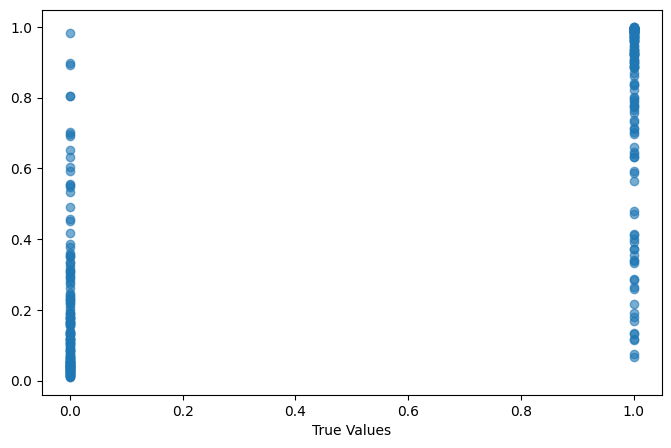

In [99]:
for epoch in range(epochs):
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    if torch.isnan(loss):
        print("Loss is NaN!")
        break
    loss.backward()
    optimiser.step()
#    if (epoch + 1) % 500 == 0:
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
print(outputs)

# Evaluate on training set
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs)
    predicted_classes = (preds > 0.5).float()
    accuracy1 = (predicted_classes == targets).float().mean()
    print(f"Training Accuracy: {accuracy1.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(targets.numpy(), preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

### testing

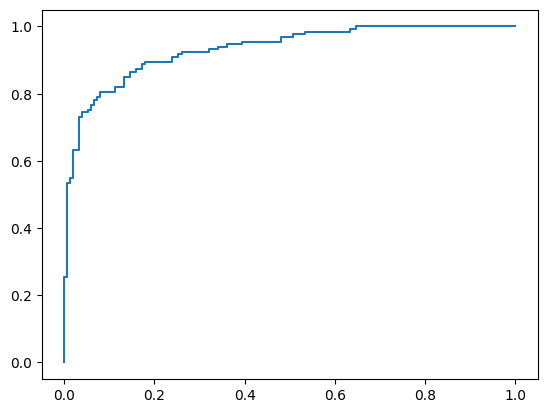

In [100]:
# roc curve
fpr1, tpr1, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(fpr1, tpr1, label = "ROC Curve")

tensor(0.5000)
Training Accuracy: 50.00%


/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


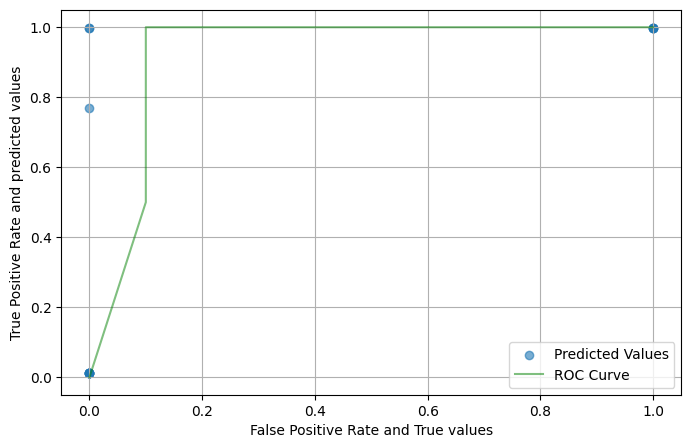

In [119]:
test = torch.sigmoid(model(test_inputs))
accuracy_test = (test > 0.5).float().mean()
print(accuracy_test)

with torch.no_grad():
    test_outputs1 = model(test_inputs)
    test_preds = torch.sigmoid(test_outputs1)
    predicted_classes = (test_preds > 0.5).float()
    test_accuracy1 = (predicted_classes == test_targets).float().mean()
    print(f"Training Accuracy: {test_accuracy1.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(test_targets.numpy(), test_preds.numpy(), alpha=0.6, label = "Predicted Values")

# roc curve
test_fpr1, test_tpr1, _ = roc_curve(test_targets.numpy(), test_preds.numpy())
plt.plot(test_fpr1, test_tpr1, label = "ROC Curve", color = "green", alpha=0.5)
plt.xlabel("False Positive Rate and True values")
plt.ylabel("True Positive Rate and predicted values")
plt.legend()
plt.grid(True)

## AI2

### setup/params.

In [102]:
class SimpleNN(nn.Module): 
    def __init__(self): 
        super(SimpleNN, self).__init__() 
        self.fc1 = nn.Linear(13, 26)
        self.celu = nn.CELU()
        self.fc2 = nn.Linear(26, 32)
        self.rrelu2 = nn.RReLU()
        self.fc3 = nn.Linear(32, 100)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(100, 64)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(64, 1) #output layer
        
    def forward(self, x): 
        x = self.fc1(x)
        x = self.celu(x)
        x = self.fc2(x)
        x = self.rrelu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        return x  # No sigmoid here; use BCEWithLogitsLoss

model = SimpleNN()
model

SimpleNN(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (celu): CELU(alpha=1.0)
  (fc2): Linear(in_features=26, out_features=32, bias=True)
  (rrelu2): RReLU(lower=0.125, upper=0.3333333333333333)
  (fc3): Linear(in_features=32, out_features=100, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=100, out_features=64, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)

### error calcs.

In [103]:
#calculate error
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

# Ensure targets are shape (N, 1)
targets = targets.view(-1, 1)
print(targets)

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

### training

In [104]:
# learning rate and epochs (variables)
epochs = 30000
lr = 0.05

Epoch [1/30000], Loss: 0.6934
Epoch [2/30000], Loss: 0.6934
Epoch [3/30000], Loss: 0.6934
Epoch [4/30000], Loss: 0.6934
Epoch [5/30000], Loss: 0.6934
Epoch [6/30000], Loss: 0.6933
Epoch [7/30000], Loss: 0.6933
Epoch [8/30000], Loss: 0.6933
Epoch [9/30000], Loss: 0.6933
Epoch [10/30000], Loss: 0.6932
Epoch [11/30000], Loss: 0.6932
Epoch [12/30000], Loss: 0.6933
Epoch [13/30000], Loss: 0.6932
Epoch [14/30000], Loss: 0.6932
Epoch [15/30000], Loss: 0.6932
Epoch [16/30000], Loss: 0.6932
Epoch [17/30000], Loss: 0.6931
Epoch [18/30000], Loss: 0.6931
Epoch [19/30000], Loss: 0.6931
Epoch [20/30000], Loss: 0.6931
Epoch [21/30000], Loss: 0.6931
Epoch [22/30000], Loss: 0.6931
Epoch [23/30000], Loss: 0.6931
Epoch [24/30000], Loss: 0.6930
Epoch [25/30000], Loss: 0.6930
Epoch [26/30000], Loss: 0.6930
Epoch [27/30000], Loss: 0.6930
Epoch [28/30000], Loss: 0.6929
Epoch [29/30000], Loss: 0.6929
Epoch [30/30000], Loss: 0.6929
Epoch [31/30000], Loss: 0.6929
Epoch [32/30000], Loss: 0.6929
Epoch [33/30000],

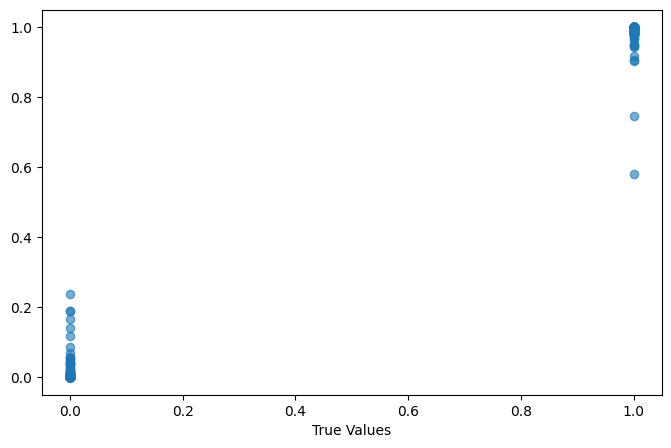

In [105]:
for epoch in range(epochs):
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    if torch.isnan(loss):
        print("Loss is NaN!")
        break
    loss.backward()
    optimiser.step()
#    if (epoch + 1) % 500 == 0:
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
print(outputs)

# Evaluate on training set
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs)
    predicted_classes = (preds > 0.5).float()
    accuracy2 = (predicted_classes == targets).float().mean()
    print(f"Training Accuracy: {accuracy2.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(targets.numpy(), preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

### testing

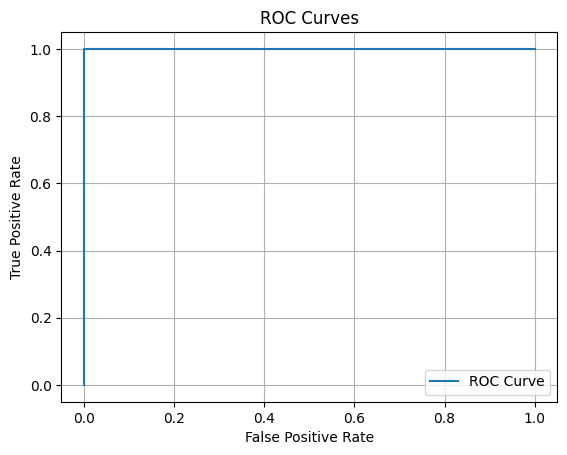

In [106]:
# roc curve
fpr2, tpr2, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(fpr2, tpr2, label = "ROC Curve")
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

tensor(0.3571)
Training Accuracy: 56.12%


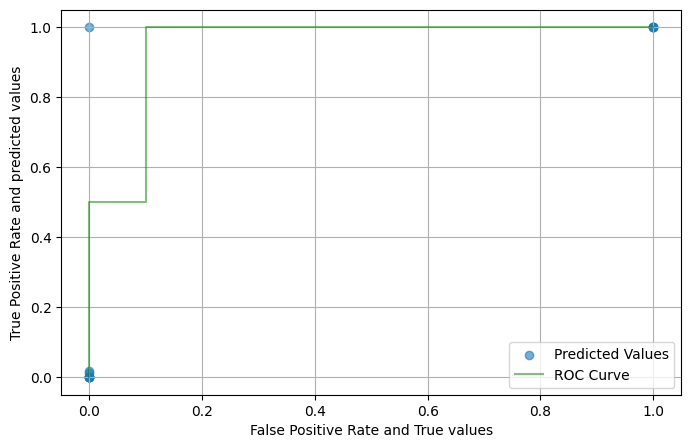

In [107]:
test = torch.sigmoid(model(test_inputs))
accuracy_test = (test > 0.5).float().mean()
print(accuracy_test)

with torch.no_grad():
    test_outputs2 = model(test_inputs)
    test_preds = torch.sigmoid(test_outputs2)
    predicted_classes = (test_preds > 0.5).float()
    test_accuracy2 = (predicted_classes == test_targets).float().mean()
    print(f"Training Accuracy: {test_accuracy2.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(test_targets.numpy(), test_preds.numpy(), alpha=0.6, label="Predicted Values")

# roc curve
test_fpr2, test_tpr2, _ = roc_curve(test_targets.numpy(), test_preds.numpy())
plt.plot(test_fpr2, test_tpr2, label = "ROC Curve", color = "green", alpha=0.5)
plt.legend()
plt.xlabel("False Positive Rate and True values")
plt.ylabel("True Positive Rate and predicted values")
plt.grid(True)

## AI3

### setup/params

In [108]:
class SimpleNN(nn.Module): 
    def __init__(self): 
        super(SimpleNN, self).__init__() 
        self.fc1 = nn.Linear(13, 26)
        self.rrelu = nn.RReLU()
        self.fc2 = nn.Linear(26, 32)
        self.silu2 = nn.SiLU()
        self.fc3 = nn.Linear(32, 26)
        self.relu3 = nn.Softmax()
        self.fc4 = nn.Linear(26, 1)  # output layer

    def forward(self, x): 
        x = self.fc1(x)
        x = self.rrelu(x)
        x = self.fc2(x)
        x = self.silu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x  # No sigmoid here; use BCEWithLogitsLoss

model = SimpleNN()
print(model)

SimpleNN(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (rrelu): RReLU(lower=0.125, upper=0.3333333333333333)
  (fc2): Linear(in_features=26, out_features=32, bias=True)
  (silu2): SiLU()
  (fc3): Linear(in_features=32, out_features=26, bias=True)
  (relu3): Softmax(dim=None)
  (fc4): Linear(in_features=26, out_features=1, bias=True)
)


### error calcs.

In [109]:
#calculate error
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

# Ensure targets are shape (N, 1)
targets = targets.view(-1, 1)
print(targets)

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

### training

In [110]:
# learning rate and epochs
epochs = 50000
lr = 0.005

/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/50000], Loss: 0.0819
Epoch [2/50000], Loss: 0.0633
Epoch [3/50000], Loss: 0.0658
Epoch [4/50000], Loss: 0.0736
Epoch [5/50000], Loss: 0.0771
Epoch [6/50000], Loss: 0.0681
Epoch [7/50000], Loss: 0.0749
Epoch [8/50000], Loss: 0.0590
Epoch [9/50000], Loss: 0.0722
Epoch [10/50000], Loss: 0.0848
Epoch [11/50000], Loss: 0.0977
Epoch [12/50000], Loss: 0.0919
Epoch [13/50000], Loss: 0.0749
Epoch [14/50000], Loss: 0.0719
Epoch [15/50000], Loss: 0.0641
Epoch [16/50000], Loss: 0.0740
Epoch [17/50000], Loss: 0.0637
Epoch [18/50000], Loss: 0.0747
Epoch [19/50000], Loss: 0.0647
Epoch [20/50000], Loss: 0.0736
Epoch [21/50000], Loss: 0.0742
Epoch [22/50000], Loss: 0.0724
Epoch [23/50000], Loss: 0.0600
Epoch [24/50000], Loss: 0.0693
Epoch [25/50000], Loss: 0.0732
Epoch [26/50000], Loss: 0.0709
Epoch [27/50000], Loss: 0.0682
Epoch [28/50000], Loss: 0.0717
Epoch [29/50000], Loss: 0.0686
Epoch [30/50000], Loss: 0.0679
Epoch [31/50000], Loss: 0.0722
Epoch [32/50000], Loss: 0.0685
Epoch [33/50000],

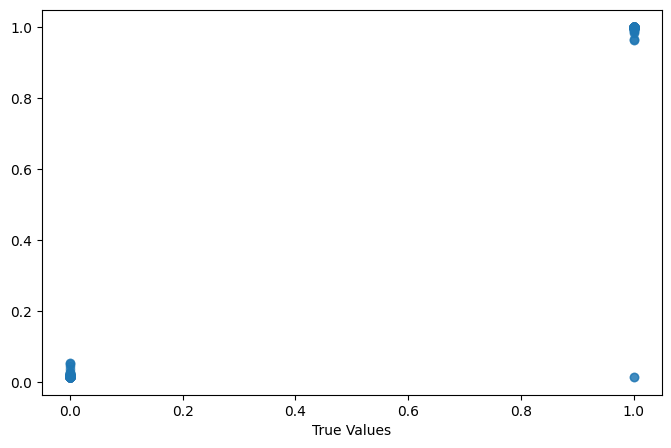

In [117]:
for epoch in range(epochs):
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    if torch.isnan(loss):
        print("Loss is NaN!")
        break
    loss.backward()
    optimiser.step()
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
print(outputs)

# Evaluate on training set
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs)
    predicted_classes = (preds > 0.5).float()
    accuracy3 = (predicted_classes == targets).float().mean()
    print(f"Training Accuracy: {accuracy3.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(targets.numpy(), preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")
print(torch.sigmoid(outputs))

### testing

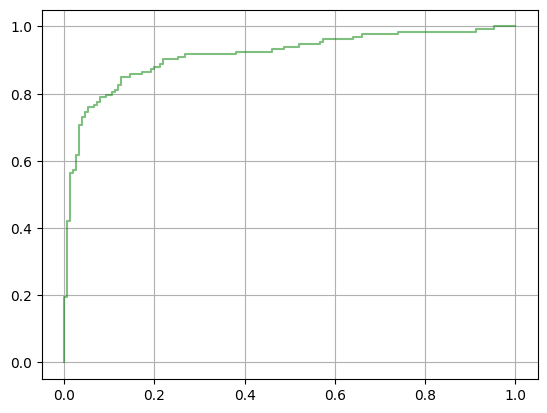

In [112]:
# roc curve
fpr3, tpr3, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(fpr3, tpr3, label = "ROC Curve", color = "green", alpha=0.5)
plt.grid(True)

tensor(0.4286)
Training Accuracy: 53.06%


/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


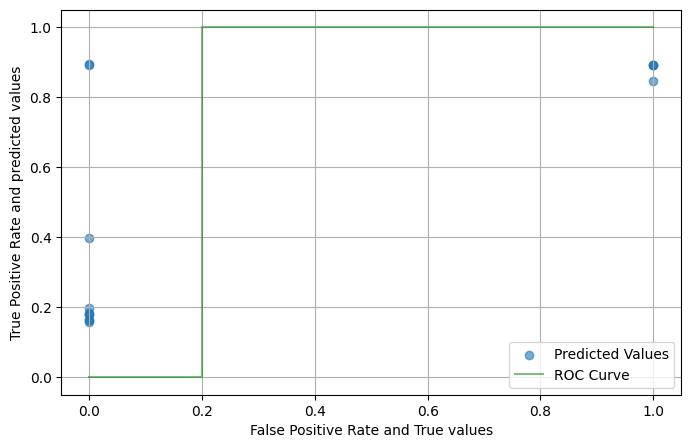

In [113]:
test = torch.sigmoid(model(test_inputs))
accuracy_test = (test > 0.5).float().mean()
print(accuracy_test)

with torch.no_grad():
    test_outputs3 = model(test_inputs)
    test_preds = torch.sigmoid(test_outputs3)
    predicted_classes = (test_preds > 0.5).float()
    test_accuracy3 = (predicted_classes == test_targets).float().mean()
    print(f"Training Accuracy: {test_accuracy3.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(test_targets.numpy(), test_preds.numpy(), alpha=0.6, label = "Predicted Values")
    plt.xlabel("True Values")

# roc curve
test_fpr3, test_tpr3, _ = roc_curve(test_targets.numpy(), test_preds.numpy())
plt.plot(test_fpr3, test_tpr3, label = "ROC Curve", color = "green", alpha=0.5)
plt.xlabel("False Positive Rate and True values")
plt.ylabel("True Positive Rate and predicted values")
plt.legend()
plt.grid(True)

## comparison

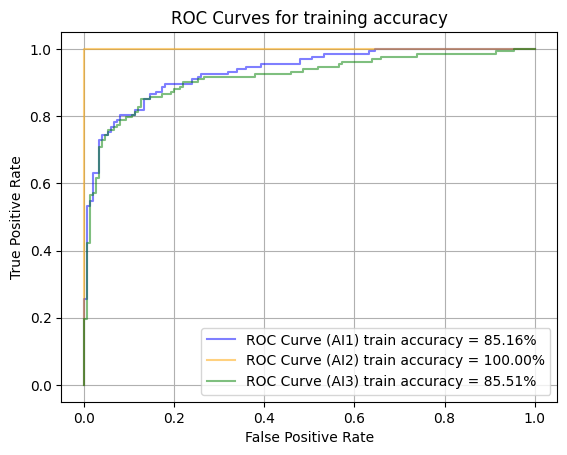

In [114]:
# roc curve
plt.plot(fpr1, tpr1, label = f"ROC Curve (AI1) train accuracy = {accuracy1.item()*100:.2f}%", c="blue", alpha=0.5) #blue
plt.plot(fpr2, tpr2, label = f"ROC Curve (AI2) train accuracy = {accuracy2.item()*100:.2f}%", c="orange", alpha=0.5) #orange
plt.plot(fpr3, tpr3, label = f"ROC Curve (AI3) train accuracy = {accuracy3.item()*100:.2f}%", c="green", alpha=0.5) #green
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for training accuracy")
plt.legend()

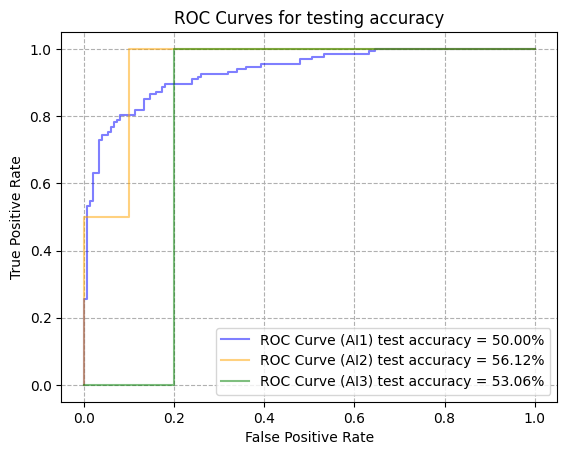

In [115]:
# roc curve
plt.plot(test_fpr1, test_tpr1, label = f"ROC Curve (AI1) test accuracy = {test_accuracy1.item()*100:.2f}%", c="blue", alpha=0.5) #blue
plt.plot(test_fpr2, test_tpr2, label = f"ROC Curve (AI2) test accuracy = {test_accuracy2.item()*100:.2f}%", c="orange", alpha=0.5) #orange
plt.plot(test_fpr3, test_tpr3, label = f"ROC Curve (AI3) test accuracy = {test_accuracy3.item()*100:.2f}%", c="green", alpha=0.5) #green
plt.grid(True, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for testing accuracy")
plt.legend()